<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%2015/3_GPax_sGP_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Structured Gaussian Processes**

This notebook compares vanilla and structured Gaussian processes for reconstructing, active learning, and optimization of function characterized by a discontinuous behavior at some "transition" point.

- Made by Maxim Ziatdinov (2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

In the previous examples, we have introduced Gaussian process (GP) operating in a fully Bayesian mode for reconstucting, with quantified uncertainty, an unknown function from sparse measurements. The limitation of the standard GP is that it does not usually allow for the incorporation of prior domain knowledge and can be biased toward a trivial interpolative solution.

We have also discussed the Bayesian Inference, including the basic concepts of prior and posterior distribution of parameters, predction mean and uncertainty, and WAIC comparison between multiple possible functions.

Recently, we introduced a structured Gaussian Process (sGP), where a classical GP is augmented by a structured probabilistic model of the expected system’s behavior. This approach allows us to balance the flexibility of the non-parametric GP approach with a rigid structure of prior (physical) knowledge encoded into the parametric model. Implementation-wise, this is achieved by substituting a zero prior mean function in GP with a probabilistic model of the expected system's behavior.

In [ ]:
!pip install numpyro==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 6.1 MB/s eta 0:00:00


Install GPax:

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 18.7 MB/s eta 0:00:00


Imports:

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import arviz as az

gpax.utils.enable_x64()

## Standard vs. structured GP

As before, we choose the example of the discontinuous function. It can be evolution of the band gap over the compositoin space, heat capacity with temperature, or any other of possible physical measurements. From practical considerations, it can be any scalar function on compact 1D space. Also, for examples we should be able to perform measurements anywhere in this parameter space (i.e. change composition or temperature). For physical measurements as a function of time, we will have to change the paradigm.

(0.0, 3.0)

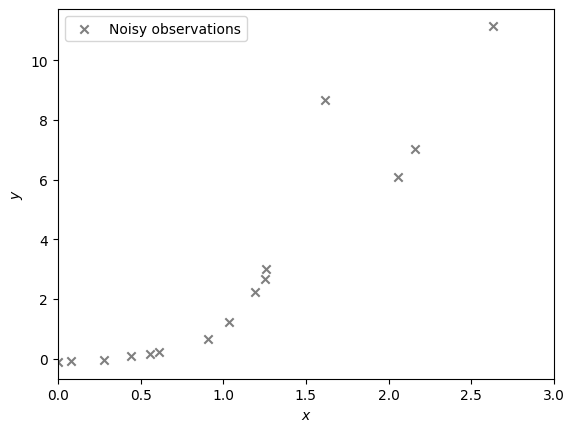

In [ ]:
def piecewise1(x: np.ndarray, params) -> np.ndarray:
    return np.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


NUM_INIT_POINTS = 15 # number of observation points
NOISE_LEVEL = 0.1
PARAMS = {"t": 1.7, "beta1": 4.5, "beta2": 2.5}

np.random.seed(1)
X = np.random.uniform(0, 3, NUM_INIT_POINTS)
y = piecewise1(X, PARAMS) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

X_test = np.linspace(0, 3, 200)

_, ax = plt.subplots(dpi=100)
ax.scatter(X, y, alpha=0.5, c='k', marker='x', label="Noisy observations")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 3)

As before, we first reconstruct this function with the standard GP

In [ ]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.01))

def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1)) #0.1 2
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale}

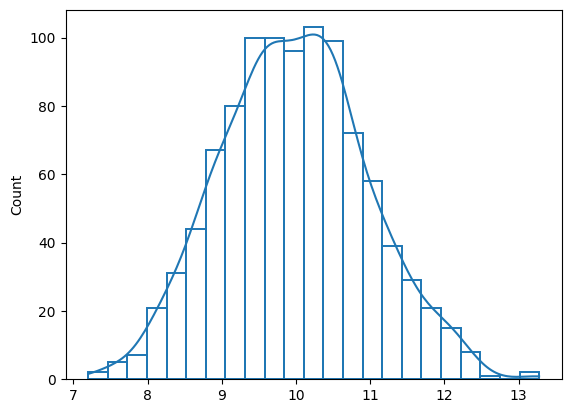

In [ ]:
d = numpyro.distributions.Normal(10, 1)
gpax.utils.dviz(d, samples=1000)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 650.03it/s, 7 steps of size 5.35e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.57      0.09      0.56      0.42      0.70   1044.17      1.00
   k_scale     18.60      8.37     16.85      7.15     29.02    799.12      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1618.07      1.00



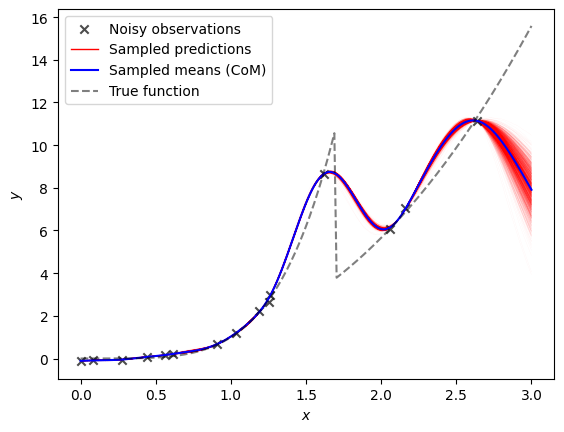

In [ ]:
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior=gp_kernel_prior, noise_prior=noise_prior)

# Run HMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='upper left')
l.set_alpha(0)

The standard GP did not perform very well. This is not surprising - remember that GP uses kernel to discover how fast the function can change. Here, we have the jump that will require kernel length to be very small (and correspondingly a lot of measurements). Also, the GP learns that there is a drop after increase - and tries to predict a drop at the edge of the interval.

Now let's try GP augmented by a probabilistic models of *expected* system's behavior. We'l need to use JAX's version of numpy for defining operations on arrays and NumPyro for placing priors over model parameters:

In [ ]:
from typing import Dict

import jax.numpy as jnp

Define possible models as deterministic functions. Notice that the first model has a correct 'guess' about the underlying function. The second model is only partially correct (it assumes the existence of transition point, but describe the behavior before and after that point as linear).

In [ ]:
def piecewise1(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


def piecewise2(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Linear behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x])

Put priors over parameters of each model (to make them probabilistic):

In [ ]:
def piecewise1_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.7))
    beta1 = numpyro.sample("beta1", numpyro.distributions.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}


def piecewise2_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.7))
    b = numpyro.sample("b", numpyro.distributions.LogNormal(0, 1))
    c = numpyro.sample("c", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

Run a 'structured' GP (*s*GP) for each model. Note that to make our GP 'structured', we pass the ```mean_fn``` (deterministic function) and ```mean_fn_prior``` (priors over the function parameters) arguments to it at the initialization stage. If we define mean fn as zero, we will revert to standard GP.

Also note that sGP is slow, so we use a fairly small number of warm-up steps and samples.

sample: 100%|██████████| 600/600 [00:17<00:00, 34.56it/s, 1023 steps of size 2.46e-03. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      3.59      1.22      4.03      1.17      4.96     11.26      1.04
      beta2      2.30      0.26      2.37      1.88      2.63     33.03      1.00
k_length[0]      1.19      0.91      0.98      0.06      2.26     68.96      1.00
    k_scale      1.60      2.89      0.90      0.06      3.28     53.03      1.00
      noise      1.42      0.75      1.21      0.45      2.51     22.21      1.00
          t      1.82      0.26      1.85      1.22      2.07     13.11      1.17



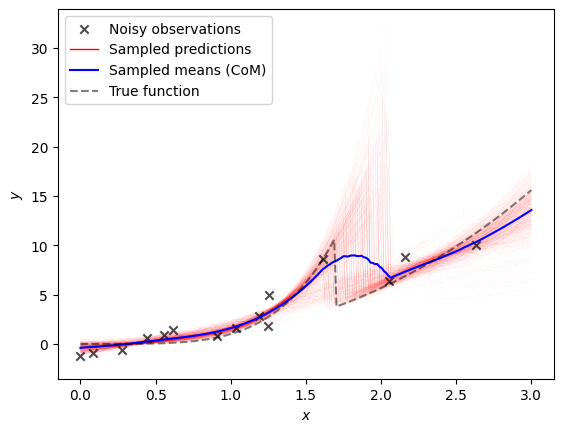

sample: 100%|██████████| 600/600 [00:16<00:00, 37.01it/s, 1023 steps of size 5.67e-04. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      0.36      0.01      0.37      0.34      0.37      2.83      2.27
          c      3.36      0.08      3.36      3.25      3.49      5.84      1.16
k_length[0]      0.41      0.01      0.41      0.39      0.42      7.11      1.07
    k_scale      1.18      0.02      1.18      1.15      1.20      5.75      1.20
      noise      0.55      0.02      0.55      0.51      0.57      3.44      1.74
          t      1.25      0.00      1.25      1.25      1.26     66.33      1.00



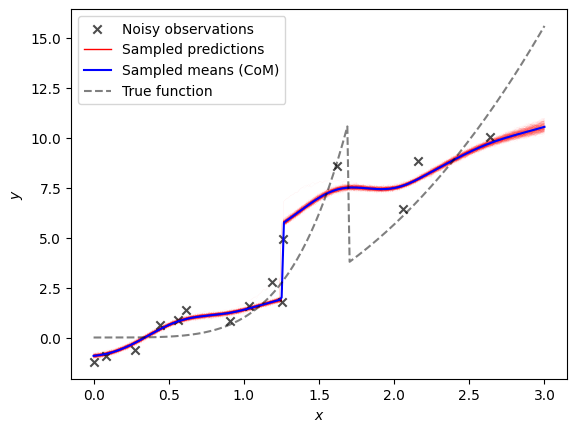

In [ ]:
mean_fn = [piecewise1, piecewise2]
mean_fn_priors = [piecewise1_priors, piecewise2_priors]

for m, mp in zip(mean_fn, mean_fn_priors):

    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=m, mean_fn_prior=mp)

    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)

    # Get GP prediction
    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

    # Plot results
    _, ax = plt.subplots(dpi=100)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
    for y1 in y_sampled:
        ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
    l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
    ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
    ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
    ax.legend(loc='upper left')
    l.set_alpha(0)
    plt.show()

We can see that the first *s*GP model performed exceptionally well, except for the transition region where we do not have enough observations. However, this region is also characterized by very large uncertainty (variation in the sampled predictions), suggesting that one may want to perform extra measurements in that area.

For the second *s*GP model, the reconstruction quality is much lower, even though it is still somewhat better than for vanilla GP. This is not surprising because the second model is much less acccurate (it assumes linear behavior before and after the transition point, which is obviously not the case here). However, even partial knowledge of the model is useful.

In [ ]:
params = gp_model.get_samples()
#params.items()

In [ ]:
# Plot 2D joint posterior distributions
# Make sure to select right variable names!

az.plot_pair(params, kind='kde', var_names=['t','b', 'c', 'k_scale'],
            divergences=False,
            textsize=18)

# show plot
plt.show()

KeyError: ignored

sample: 100%|██████████| 600/600 [00:06<00:00, 88.76it/s, 63 steps of size 2.38e-02. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.47      0.06      4.47      4.40      4.57    106.34      1.04
      beta2      2.47      0.04      2.48      2.42      2.53    151.06      1.00
k_length[0]      3.55      2.70      3.06      0.49      6.84    174.97      1.00
    k_scale      0.55      0.61      0.35      0.01      1.29    227.52      1.00
      noise      0.03      0.02      0.02      0.01      0.04     23.33      1.01
          t      1.82      0.12      1.81      1.63      2.01     46.65      1.03



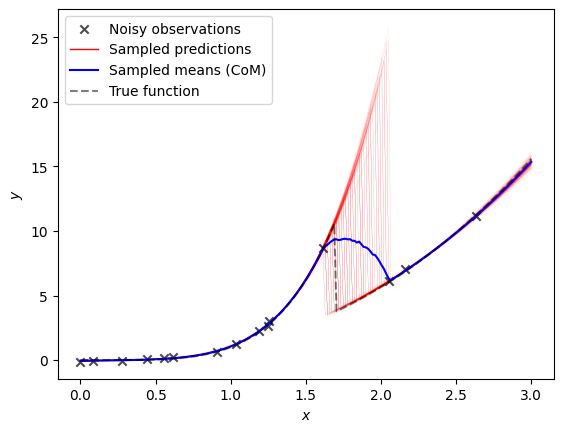

In [ ]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)

# Run MCMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)

# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
  ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='upper left')
l.set_alpha(0)
plt.show()

In [ ]:
params = gp_model.get_samples()
# params.items()

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:221: UserWarning: More chains (400) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


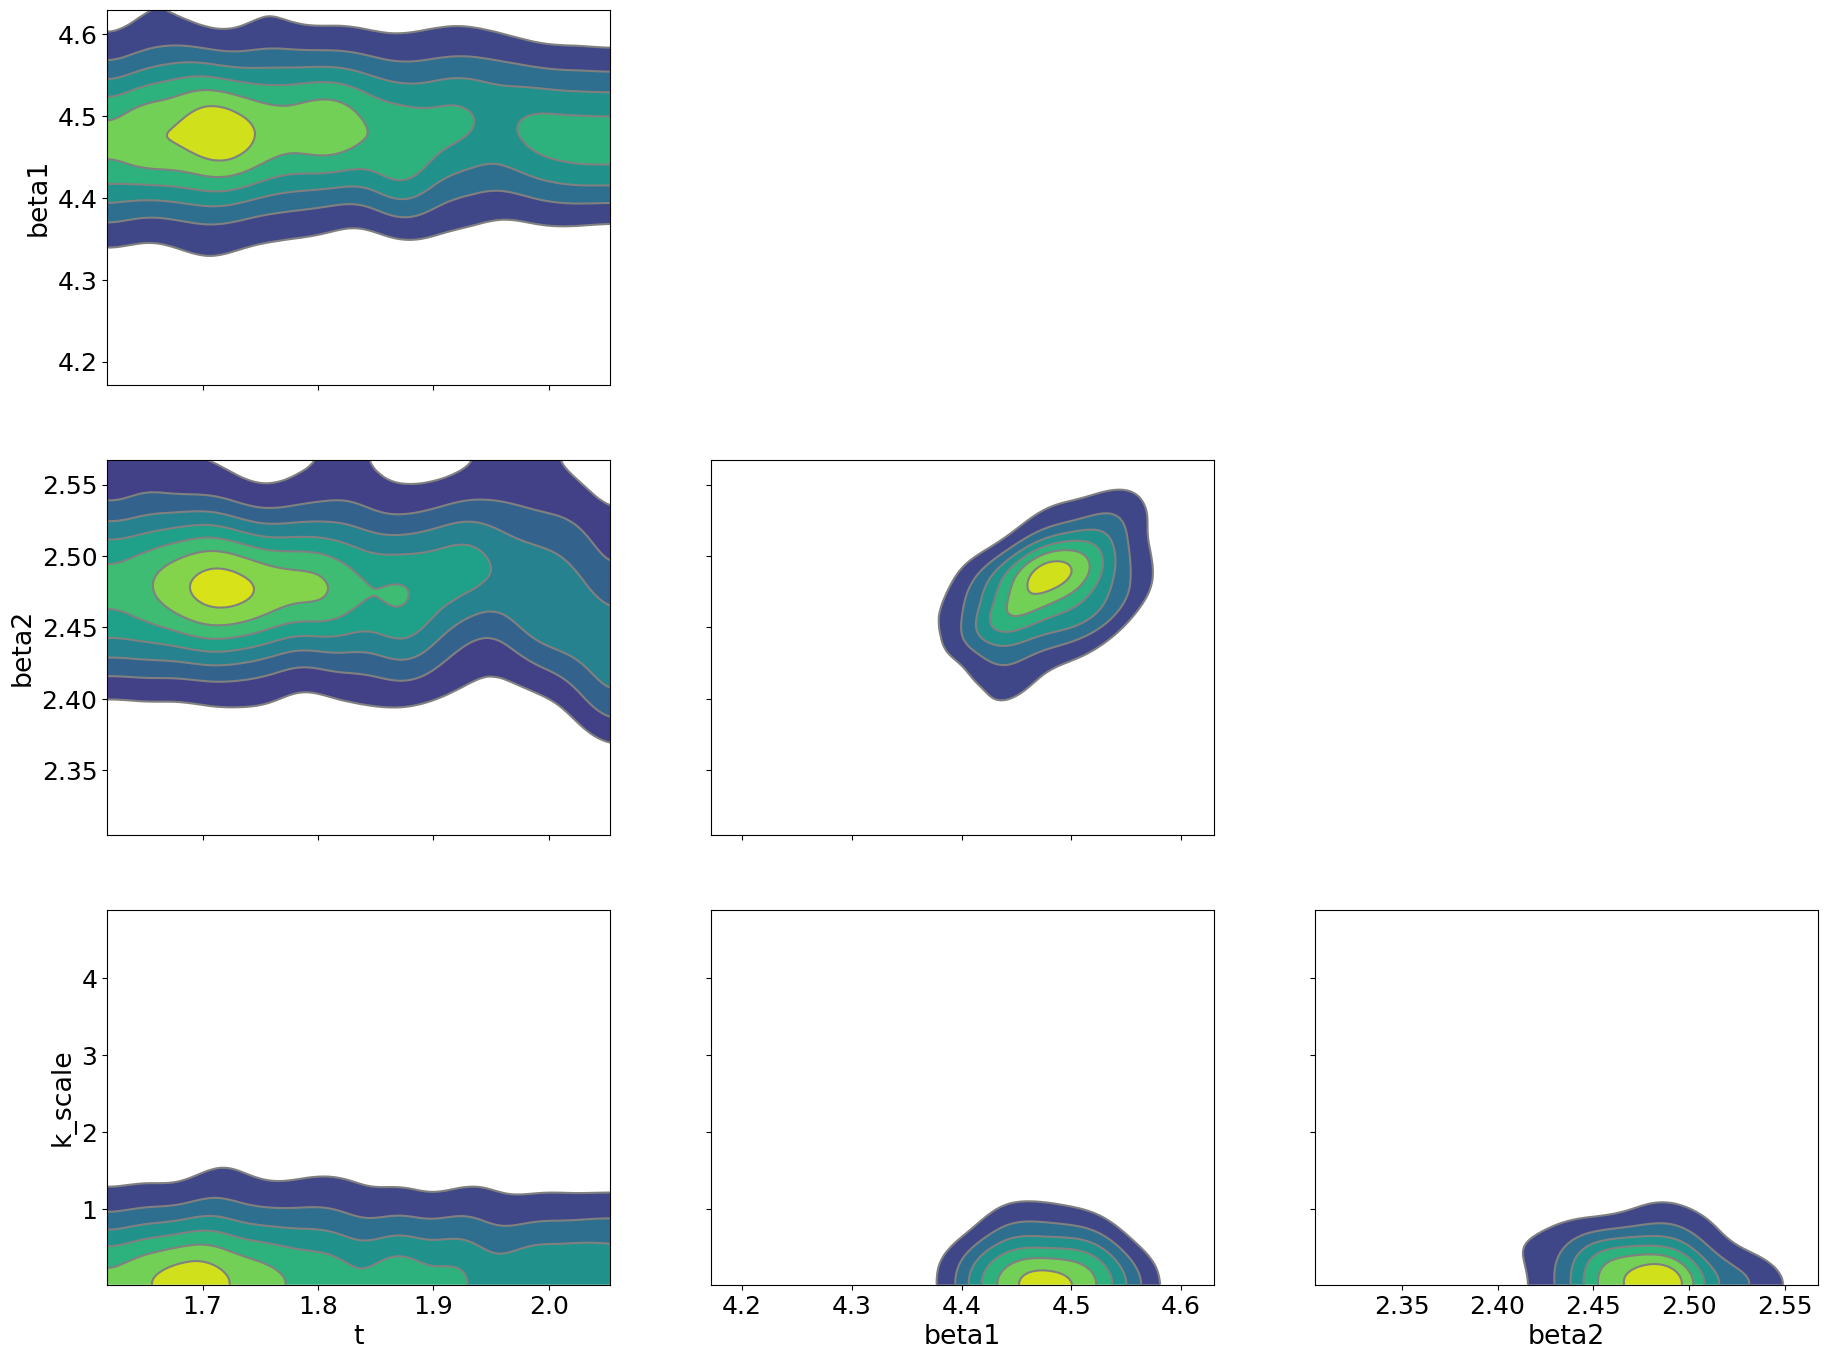

In [ ]:
# Plot 2D joint posterior distributions
# Make sure to select right variable names!

az.plot_pair(params, kind='kde', var_names=['t','beta1', 'beta2', 'k_scale'],
            divergences=False,
            textsize=18)

# show plot
plt.show()

## Simple active learning with structured GP

We can further explore regions with high uncertainty using the active learning approach. In this approach, the next evaluation point is selected according to $$x_{next}=\arg \max_x𝜎[f_*]$$

where $𝜎$ is the uncertainty in prediction of function $f_*$ over the parameter range $x$.

First, we are going to use the model that produced the lowest total uncertainty on the original set of observations. We are also going to generate a bit more data - but now with smaller number of sampling points.

(0.0, 3.0)

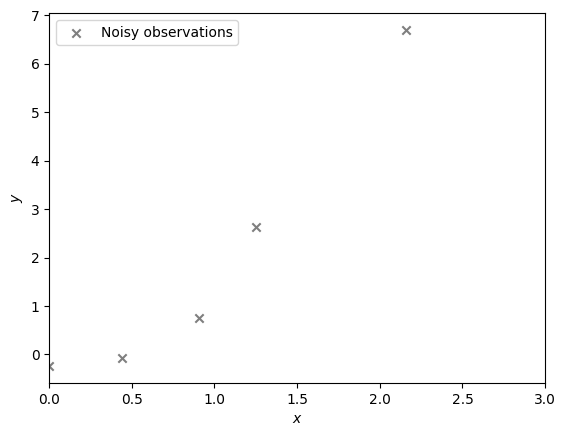

In [ ]:
def piecewise1d(x: np.ndarray, params) -> np.ndarray:
    return np.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


NUM_INIT_POINTS = 5 # number of observation points
NOISE_LEVEL = 0.1
PARAMS = {"t": 1.7, "beta1": 4.5, "beta2": 2.5}

np.random.seed(1)
X = np.random.uniform(0, 3, NUM_INIT_POINTS)
y = piecewise1d(X, PARAMS) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

X_test = np.linspace(0, 3, 200)

_, ax = plt.subplots(dpi=100)
ax.scatter(X, y, alpha=0.5, c='k', marker='x', label="Noisy observations")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 3)

In [ ]:
# Copy the initial observations so that we can re-use them later
Xo, yo = X.copy(), y.copy()

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)

for i in range(6):
    print("\nExploration step {}".format(i+1))

    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
    gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1, print_summary=1)

    # Compute acquisition function (here it is simply the uncertinty in prediciton)
    # and get the coordinate of the next point to measure
    obj = gpax.acquisition.UE(rng_key_predict, gp_model, X_test)
    next_point_idx = obj.argmax()

     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)



Exploration step 1


sample: 100%|██████████| 600/600 [00:07<00:00, 83.61it/s, 1023 steps of size 3.02e-04. acc. prob=0.98] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.62      0.93      2.45      0.80      3.65     16.90      1.16
      beta2      2.26      0.48      2.34      1.36      2.96      7.45      1.02
k_length[0]      1.79      0.95      1.58      0.61      3.09     14.72      1.06
    k_scale      4.06      1.74      3.96      1.41      6.63      4.19      1.48
      noise      0.71      0.62      0.40      0.21      1.82      4.14      1.41
          t      1.64      0.50      1.56      0.98      2.54      6.84      1.56


Exploration step 2


sample: 100%|██████████| 600/600 [00:05<00:00, 115.14it/s, 63 steps of size 1.13e-01. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      1.86      1.49      1.50      0.03      3.96    123.00      1.01
      beta2      2.49      0.07      2.49      2.37      2.59    134.71      1.02
k_length[0]      1.52      1.47      1.07      0.12      3.17    143.16      1.01
    k_scale      0.85      1.01      0.55      0.06      1.82    165.09      1.00
      noise      0.60      0.53      0.43      0.06      1.21    133.73      1.02
          t      1.26      0.52      1.18      0.50      1.98     83.81      1.01


Exploration step 3


sample: 100%|██████████| 600/600 [00:07<00:00, 78.93it/s, 511 steps of size 5.11e-03. acc. prob=0.80]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.29      1.71      2.00      0.12      4.59    181.05      1.00
      beta2      2.49      0.06      2.50      2.40      2.58    222.27      1.00
k_length[0]      1.84      2.01      1.18      0.09      4.31    169.33      1.00
    k_scale      0.76      0.77      0.51      0.03      1.69    186.55      1.00
      noise      0.48      0.44      0.35      0.03      1.04    130.21      1.00
          t      1.23      0.47      1.20      0.50      1.85     78.07      1.00


Exploration step 4


sample: 100%|██████████| 600/600 [00:07<00:00, 79.87it/s, 831 steps of size 6.60e-03. acc. prob=0.74]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.71      2.98      2.34      0.12      4.43    116.90      1.00
      beta2      2.50      0.05      2.50      2.40      2.57    168.71      1.00
k_length[0]      1.65      1.64      1.25      0.10      3.13    122.09      1.00
    k_scale      0.66      0.64      0.46      0.05      1.38     83.49      1.00
      noise      0.33      0.27      0.25      0.04      0.63    127.50      1.00
          t      1.30      0.50      1.24      0.53      1.89     66.33      1.02


Exploration step 5


sample: 100%|██████████| 600/600 [00:09<00:00, 63.61it/s, 1023 steps of size 2.73e-03. acc. prob=0.80] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      3.03      1.74      3.17      0.27      4.75     71.66      1.01
      beta2      2.49      0.05      2.50      2.43      2.59     96.66      1.00
k_length[0]      2.39      2.83      1.57      0.10      5.56    110.21      1.00
    k_scale      0.61      0.69      0.38      0.05      1.34    149.95      1.00
      noise      0.23      0.25      0.16      0.02      0.47    111.87      1.00
          t      1.31      0.46      1.39      0.50      1.84     57.32      1.00


Exploration step 6


sample: 100%|██████████| 600/600 [00:10<00:00, 54.94it/s, 1023 steps of size 2.35e-03. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.88      2.09      2.74      0.23      4.71     96.34      1.00
      beta2      2.50      0.04      2.50      2.43      2.57    167.65      1.01
k_length[0]      2.02      1.94      1.43      0.05      4.22     89.80      1.01
    k_scale      0.60      0.54      0.44      0.08      1.23     64.69      1.00
      noise      0.21      0.20      0.15      0.03      0.42     66.35      1.03
          t      1.22      0.50      1.27      0.50      1.77     26.28      1.01



Make the prediction using all the newly discovered points:

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)

# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)

# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

sample: 100%|██████████| 600/600 [00:11<00:00, 50.11it/s, 1023 steps of size 3.85e-03. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.51      0.10      4.51      4.37      4.68    127.58      1.00
      beta2      2.50      0.04      2.50      2.44      2.56    161.68      1.00
k_length[0]      3.35      2.55      2.61      0.27      7.35     42.32      1.01
    k_scale      0.71      0.80      0.46      0.07      1.41     51.08      1.01
      noise      0.14      0.16      0.10      0.02      0.29     13.45      1.17
          t      1.72      0.05      1.71      1.65      1.79     83.27      1.00



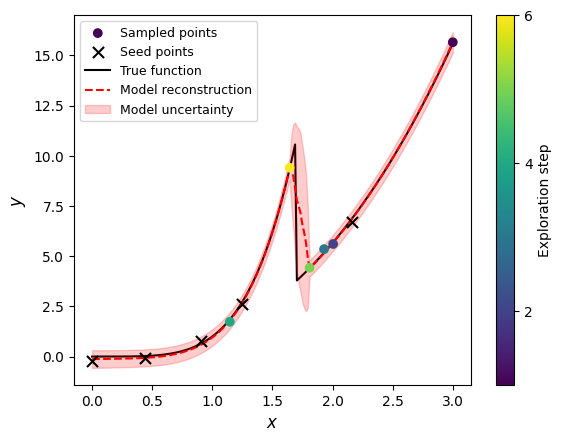

In [ ]:
# Plot results
truefunc = piecewise1(X_test, PARAMS)
seed_points = NUM_INIT_POINTS

plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=0)

plt.fill_between(X_test, y_pred - y_sampled.std((0,1)), y_pred + y_sampled.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Now we are going do active learning with the 'wrong' (or partially correct, depending on whether you are pessimist or optimist) model. We will start from the same set of observations as before.

In [ ]:
X, y = Xo, yo  # start from the same set of observations

rng_key, rng_key_predict = gpax.utils.get_keys(1)

for i in range(9):
    print("\nExploration step {}".format(i+1))
    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
    gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1, print_summary=1)

    # Compute acquisition function and get coordinate of the next point
    obj = gpax.acquisition.UE(rng_key_predict, gp_model, X_test)
    next_point_idx = obj.argmax()

     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)



Exploration step 1


sample: 100%|██████████| 600/600 [00:07<00:00, 80.68it/s, 1023 steps of size 1.75e-03. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.34      0.95      1.11      0.04      2.61     27.02      1.08
          c      3.55      1.60      3.00      1.43      5.90     10.81      1.16
k_length[0]      1.62      1.74      0.97      0.09      3.77     64.05      1.00
    k_scale      1.22      1.07      0.95      0.14      2.52     43.84      1.03
      noise      0.91      0.98      0.62      0.08      1.81     97.67      1.01
          t      1.48      0.64      1.33      0.50      2.49     18.08      1.10


Exploration step 2


sample: 100%|██████████| 600/600 [00:07<00:00, 80.33it/s, 1023 steps of size 3.29e-04. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.94      0.69      2.99      1.81      4.00     28.75      1.00
          c      5.41      0.70      5.23      4.54      6.68      5.99      1.13
k_length[0]      1.34      0.98      1.09      0.30      2.24     12.36      1.10
    k_scale      4.06      2.91      3.15      0.64      8.54      4.93      1.45
      noise      0.68      0.69      0.30      0.16      1.93      3.83      1.45
          t      2.42      0.15      2.43      2.21      2.64     15.76      1.00


Exploration step 3


sample: 100%|██████████| 600/600 [00:08<00:00, 73.66it/s, 1023 steps of size 3.00e-03. acc. prob=0.74] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.82      1.18      1.61      0.26      3.56     65.59      1.00
          c      4.30      0.62      4.28      3.33      5.33    138.03      1.00
k_length[0]      1.20      1.32      0.81      0.08      2.55    164.40      1.00
    k_scale      2.21      2.11      1.64      0.13      4.88    108.09      1.00
      noise      1.85      1.43      1.48      0.06      3.83    105.85      1.01
          t      1.73      0.59      1.81      0.83      2.68     81.01      1.00


Exploration step 4


sample: 100%|██████████| 600/600 [00:07<00:00, 81.95it/s, 639 steps of size 8.86e-03. acc. prob=0.68] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.24      1.13      2.27      0.40      3.66     38.77      1.00
          c      4.36      0.69      4.35      2.99      5.29     52.71      1.00
k_length[0]      1.02      0.92      0.86      0.14      1.80    212.06      1.01
    k_scale      2.74      2.90      1.93      0.03      5.52    148.58      1.00
      noise      1.44      1.40      1.03      0.09      3.14    118.64      1.01
          t      1.74      0.67      1.88      0.82      2.69     30.80      1.06


Exploration step 5


sample: 100%|██████████| 600/600 [00:08<00:00, 66.82it/s, 1023 steps of size 3.95e-03. acc. prob=0.69] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.20      1.22      2.30      0.14      3.74     63.02      1.00
          c      4.23      0.73      4.33      3.14      5.47     38.91      1.01
k_length[0]      1.08      1.06      0.86      0.15      1.70     88.09      1.00
    k_scale      3.41      3.22      2.52      0.17      6.84     52.84      1.00
      noise      1.06      1.04      0.69      0.09      2.36     96.16      1.00
          t      1.71      0.71      1.83      0.70      2.68     41.10      1.05


Exploration step 6


sample: 100%|██████████| 600/600 [00:10<00:00, 56.23it/s, 1023 steps of size 1.64e-03. acc. prob=0.80]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.65      1.32      2.57      0.29      4.60     25.71      1.01
          c      4.36      0.76      4.33      3.26      5.64     27.78      1.00
k_length[0]      1.03      0.57      0.92      0.30      1.79     38.88      1.01
    k_scale      4.74      4.45      3.49      0.43      8.71     31.37      1.00
      noise      0.73      0.75      0.43      0.03      1.78     29.88      1.03
          t      1.43      0.69      1.20      0.51      2.54     22.65      1.00


Exploration step 7


sample: 100%|██████████| 600/600 [00:11<00:00, 50.80it/s, 1023 steps of size 5.31e-04. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      3.48      1.22      3.46      1.39      5.38     24.09      1.02
          c      4.97      0.48      4.95      4.20      5.88      8.77      1.09
k_length[0]      1.02      0.31      1.03      0.49      1.46     19.14      1.09
    k_scale      4.51      2.38      4.74      0.19      7.53      6.60      1.15
      noise      0.61      0.60      0.44      0.06      1.27      6.53      1.02
          t      1.40      0.66      1.18      0.69      2.63      5.66      1.40


Exploration step 8


sample: 100%|██████████| 600/600 [00:10<00:00, 56.44it/s, 1023 steps of size 1.06e-03. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      3.18      1.43      3.21      0.76      5.47     25.80      1.02
          c      4.46      0.78      4.43      3.17      5.58     30.31      1.09
k_length[0]      1.11      0.33      1.09      0.51      1.59     18.29      1.13
    k_scale      6.99      3.92      6.02      1.95     13.51      5.52      1.42
      noise      0.28      0.24      0.20      0.05      0.59     12.68      1.16
          t      1.26      0.69      0.99      0.50      2.51     18.96      1.08


Exploration step 9


sample: 100%|██████████| 600/600 [00:12<00:00, 47.02it/s, 1023 steps of size 7.04e-04. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      3.48      1.63      3.48      1.00      6.28     24.64      1.01
          c      4.79      0.68      4.75      3.78      5.81      6.32      1.43
k_length[0]      0.97      0.32      0.91      0.48      1.50     13.65      1.01
    k_scale      6.19      3.74      4.86      1.98     11.63      9.60      1.09
      noise      0.20      0.20      0.13      0.03      0.45     11.83      1.11
          t      1.02      0.50      0.81      0.50      1.85     18.14      1.00



Make the prediction using all the newly discovered points:

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)
# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)
# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

sample: 100%|██████████| 600/600 [00:13<00:00, 43.26it/s, 1023 steps of size 1.38e-04. acc. prob=0.97]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.52      0.84      2.45      1.39      3.72      2.83      2.35
          c      4.95      0.46      5.10      3.95      5.43      4.40      1.28
k_length[0]      0.65      0.10      0.62      0.53      0.75      4.43      1.43
    k_scale      6.67      1.50      7.03      3.89      8.55      3.06      2.11
      noise      0.18      0.09      0.14      0.11      0.34      3.89      1.39
          t      0.62      0.07      0.61      0.53      0.73      8.66      1.18



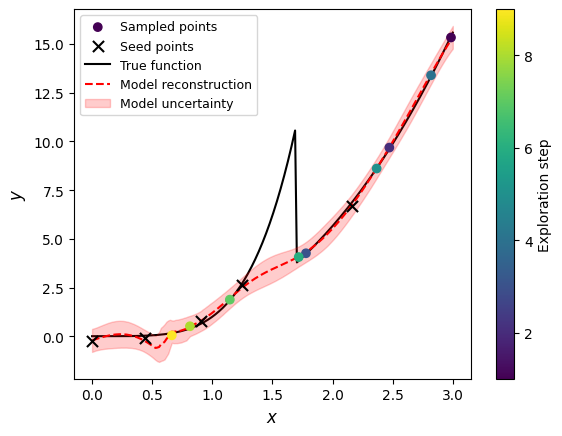

In [ ]:
# Plot results
plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=0)

plt.fill_between(X_test, y_pred - y_sampled.std((0,1)), y_pred + y_sampled.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Even though it required more steps (and each step took longer to converge), it is still able to reconstuct the underlying discontinuous function. Note that the vanilla GP won't be able to do so (you can check it by removing the mean_fn and mean_fn_prior arguments from the GP initialization and rerunning the process).

# Bayesian Optimization with structured GP

Now, we can use the sGP for the Bayesian Optimization using the same acquisition functions in GPax. Do not forget to keep track of the arguments maximize and select argmin(acquisition function) or argmax(acquisition function) depending on whether this is maximization or minimization problem.


Exploration step 1


sample: 100%|██████████| 600/600 [00:07<00:00, 80.38it/s, 1023 steps of size 3.02e-04. acc. prob=0.98] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.62      0.93      2.45      0.80      3.65     16.90      1.16
      beta2      2.26      0.48      2.34      1.36      2.96      7.45      1.02
k_length[0]      1.79      0.95      1.58      0.61      3.09     14.72      1.06
    k_scale      4.06      1.74      3.96      1.41      6.63      4.19      1.48
      noise      0.71      0.62      0.40      0.21      1.82      4.14      1.41
          t      1.64      0.50      1.56      0.98      2.54      6.84      1.56



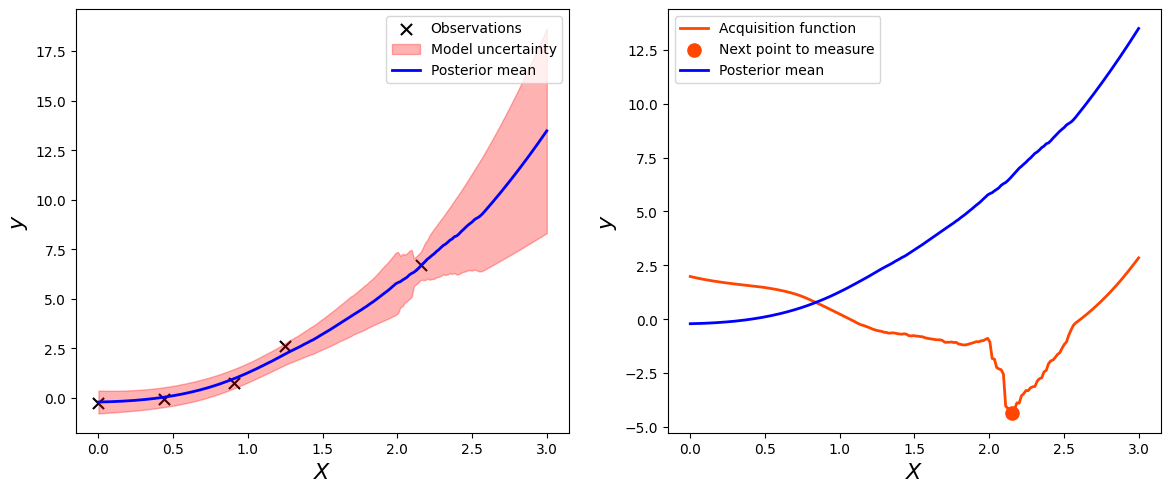


Exploration step 2


sample: 100%|██████████| 600/600 [00:05<00:00, 106.63it/s, 129 steps of size 4.65e-02. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.18      1.79      1.95      0.16      4.23    138.51      1.01
      beta2      2.51      0.78      2.39      1.48      2.79     13.93      1.08
k_length[0]      1.59      1.68      1.08      0.08      3.66    168.56      1.00
    k_scale      1.25      1.52      0.76      0.04      2.70     65.48      1.00
      noise      0.51      0.52      0.34      0.02      1.13    148.64      1.00
          t      1.38      0.63      1.27      0.50      2.30     19.92      1.03



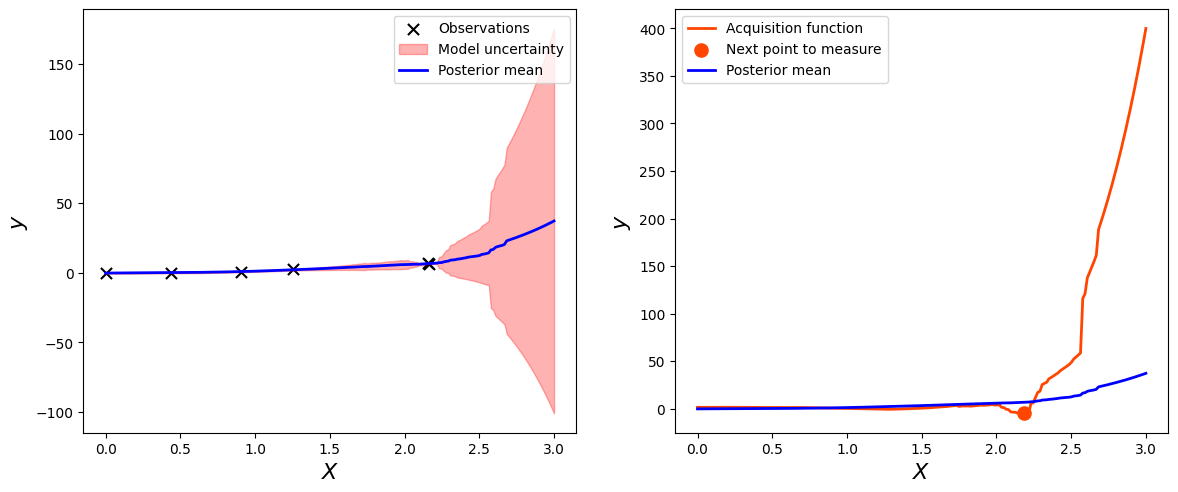


Exploration step 3


sample: 100%|██████████| 600/600 [00:07<00:00, 81.42it/s, 511 steps of size 7.67e-03. acc. prob=0.77] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.44      1.87      2.35      0.16      4.00    124.50      1.00
      beta2      2.46      0.84      2.37      0.88      3.57     11.38      1.11
k_length[0]      1.49      1.53      1.03      0.09      3.11     88.00      1.00
    k_scale      1.25      1.49      0.74      0.07      2.68     92.46      1.01
      noise      0.38      0.35      0.26      0.02      0.78    219.18      1.01
          t      1.77      0.68      1.89      0.76      2.69     35.38      1.03



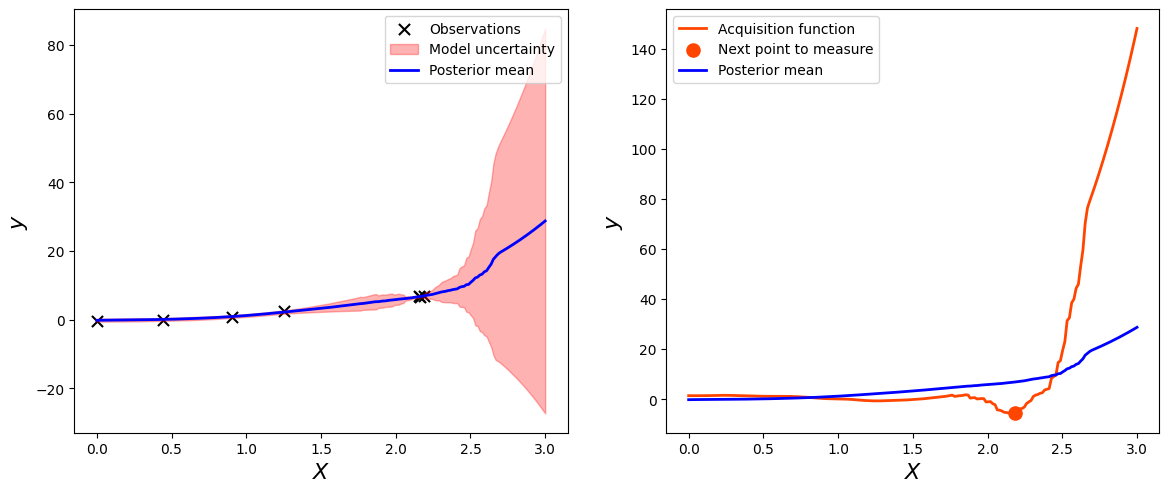


Exploration step 4


sample: 100%|██████████| 600/600 [00:07<00:00, 77.56it/s, 511 steps of size 4.79e-03. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.71      2.07      2.38      0.25      4.96    193.81      1.00
      beta2      2.32      0.30      2.41      1.75      2.80     21.46      1.04
k_length[0]      1.60      1.81      1.07      0.08      3.55    135.15      1.02
    k_scale      0.93      1.01      0.60      0.04      2.03    186.58      1.00
      noise      0.24      0.23      0.17      0.02      0.53    160.05      1.00
          t      1.47      0.63      1.44      0.50      2.38     32.17      1.11



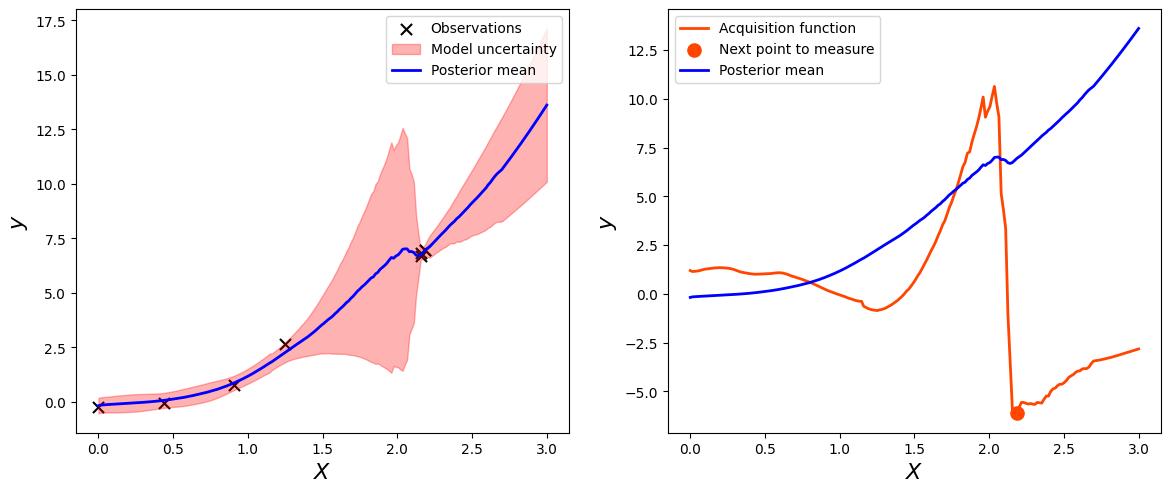


Exploration step 5


sample: 100%|██████████| 600/600 [00:09<00:00, 63.04it/s, 1023 steps of size 2.77e-04. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.66      0.89      2.52      1.21      4.24      5.63      1.63
      beta2      2.10      0.15      2.17      1.80      2.25      3.37      1.68
k_length[0]      2.07      0.94      1.86      0.86      3.43     10.46      1.36
    k_scale      4.03      1.53      3.86      1.58      6.35      6.86      1.30
      noise      0.18      0.17      0.11      0.04      0.44      4.74      1.37
          t      1.59      0.51      1.48      0.97      2.59      6.83      1.14



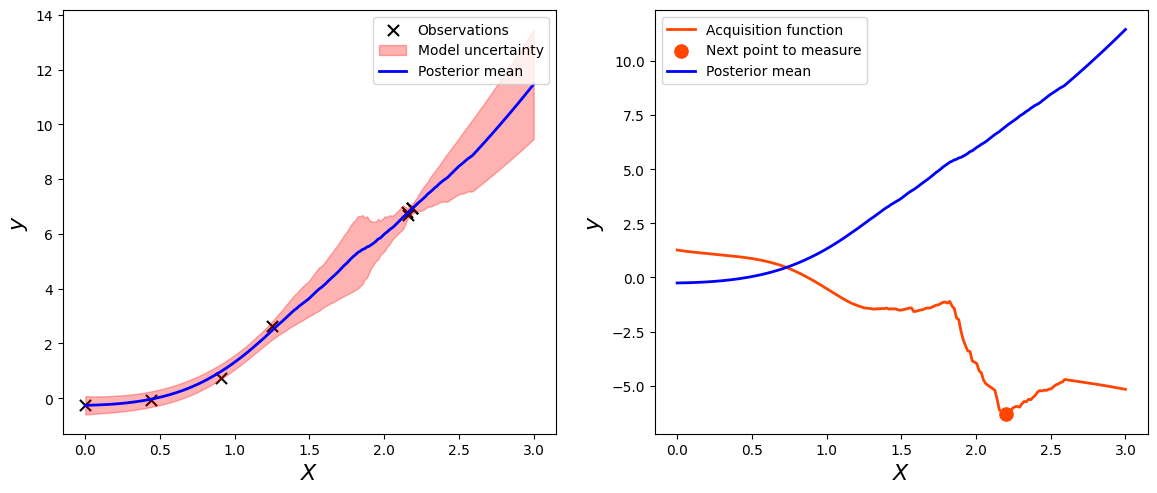


Exploration step 6


sample: 100%|██████████| 600/600 [00:09<00:00, 65.58it/s, 511 steps of size 3.71e-03. acc. prob=0.83]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      2.80      1.63      2.85      0.07      4.50    100.93      1.00
      beta2      2.37      0.26      2.43      2.10      2.66     25.36      1.01
k_length[0]      1.37      1.30      1.01      0.09      2.74    112.38      1.00
    k_scale      0.93      1.09      0.60      0.09      1.97     46.18      1.00
      noise      0.13      0.13      0.09      0.01      0.27    141.35      1.03
          t      1.41      0.48      1.45      0.66      2.11     67.80      1.00



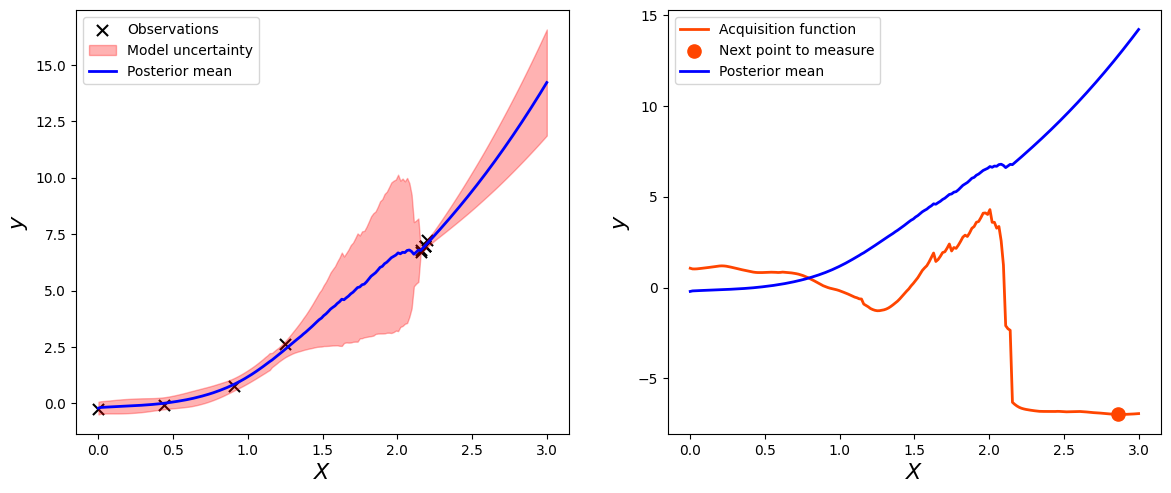

In [ ]:
X, y = Xo, yo  # start from the same set of observations

rng_key, rng_key_predict = gpax.utils.get_keys(1)

for i in range(6):
    print("\nExploration step {}".format(i+1))

    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
    gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1, print_summary=1)

    # Compute acquisition function (here it is simply the uncertinty in prediciton)
    # and get the coordinate of the next point to measure
    #obj = gpax.acquisition.UE(rng_key_predict, gp_model, X_test)

    #Upper confidence bound
    obj = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta= 10, maximize=False, noiseless=True)

    #Expected improvement
    #obj = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, xi=0.01, maximize=False, n=10, noiseless=True) #xi = 0.01

    next_point_idx = obj.argmin()

     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)

    # Plot observed points, mean prediction, and acqusition function
    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=True, n= 10)

    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))

    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_test, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_test, obj, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_test[next_point_idx], obj[next_point_idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_test, y_pred, lw=2, c='b', label='Posterior mean')
        #ax.plot(X_test, truefunc, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

Make the prediction using all the newly discovered points:

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)

# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)

# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

sample: 100%|██████████| 600/600 [00:05<00:00, 103.62it/s, 15 steps of size 1.52e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.47      0.05      4.47      4.39      4.54    263.13      1.00
      beta2      2.49      0.02      2.49      2.46      2.52    193.80      1.00
k_length[0]      4.23      3.07      3.29      0.31      7.96    159.62      1.00
    k_scale      0.57      0.62      0.38      0.02      1.22     84.64      1.00
      noise      0.02      0.01      0.02      0.01      0.03     72.12      1.03
          t      1.86      0.13      1.87      1.67      2.06     46.32      1.04



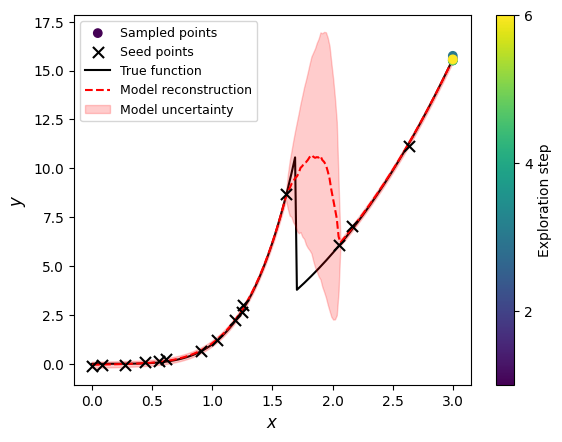

In [ ]:
# Plot results
truefunc = piecewise1(X_test, PARAMS)
seed_points = NUM_INIT_POINTS

plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=0)

plt.fill_between(X_test, y_pred - y_sampled.std((0,1)), y_pred + y_sampled.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Now we are going do active learning with the 'wrong' (or partially correct, depending on whether you are pessimist or optimist) model. We will start from the same set of observations as before.


Exploration step 1


sample: 100%|██████████| 600/600 [00:07<00:00, 79.74it/s, 1023 steps of size 1.75e-03. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.34      0.95      1.11      0.04      2.61     27.02      1.08
          c      3.55      1.60      3.00      1.43      5.90     10.81      1.16
k_length[0]      1.62      1.74      0.97      0.09      3.77     64.05      1.00
    k_scale      1.22      1.07      0.95      0.14      2.52     43.84      1.03
      noise      0.91      0.98      0.62      0.08      1.81     97.67      1.01
          t      1.48      0.64      1.33      0.50      2.49     18.08      1.10



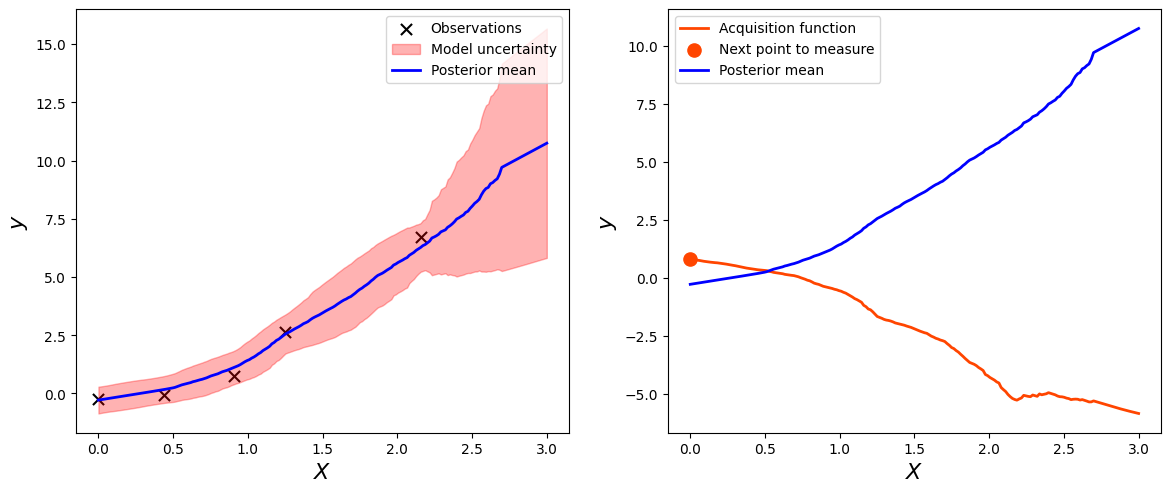


Exploration step 2


sample: 100%|██████████| 600/600 [00:06<00:00, 87.63it/s, 511 steps of size 7.55e-03. acc. prob=0.75] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.26      0.80      1.12      0.08      2.42    111.25      1.00
          c      2.73      0.58      2.73      1.91      3.74     64.14      1.03
k_length[0]      1.51      1.48      1.03      0.07      3.16    179.81      1.02
    k_scale      1.31      1.75      0.86      0.02      2.68    137.71      1.01
      noise      0.67      0.62      0.48      0.06      1.60    244.06      1.00
          t      1.40      0.53      1.27      0.51      2.16     77.42      1.00



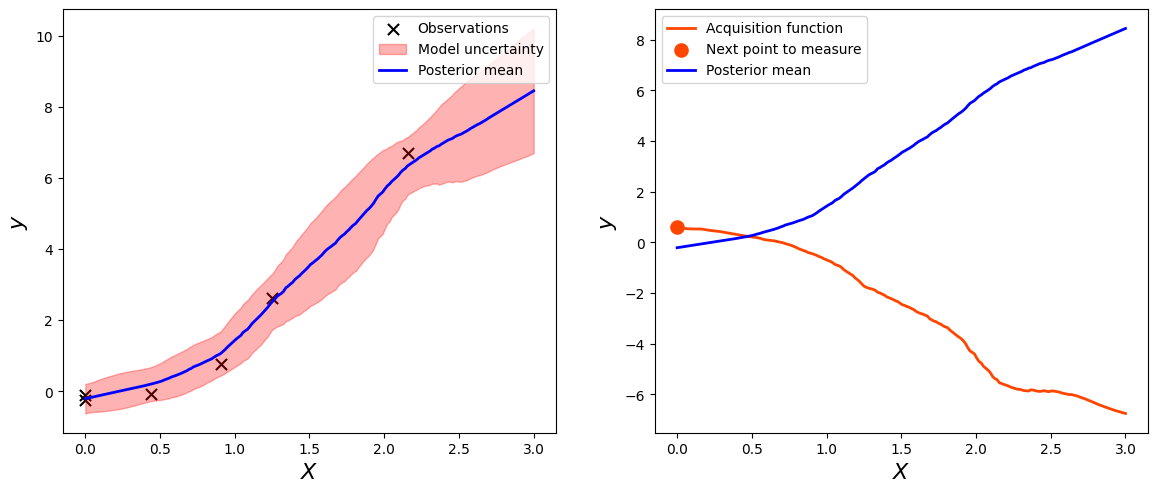


Exploration step 3


sample: 100%|██████████| 600/600 [00:08<00:00, 68.09it/s, 1023 steps of size 2.65e-03. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.47      0.93      1.33      0.09      2.74     44.20      1.00
          c      2.73      1.62      2.65      0.69      3.80     70.74      1.04
k_length[0]      1.23      0.89      1.01      0.06      2.47     65.95      1.01
    k_scale      1.29      1.15      0.94      0.04      2.97     61.69      1.00
      noise      0.52      0.43      0.38      0.06      1.08    168.33      1.02
          t      1.48      0.66      1.34      0.50      2.52     35.31      1.00



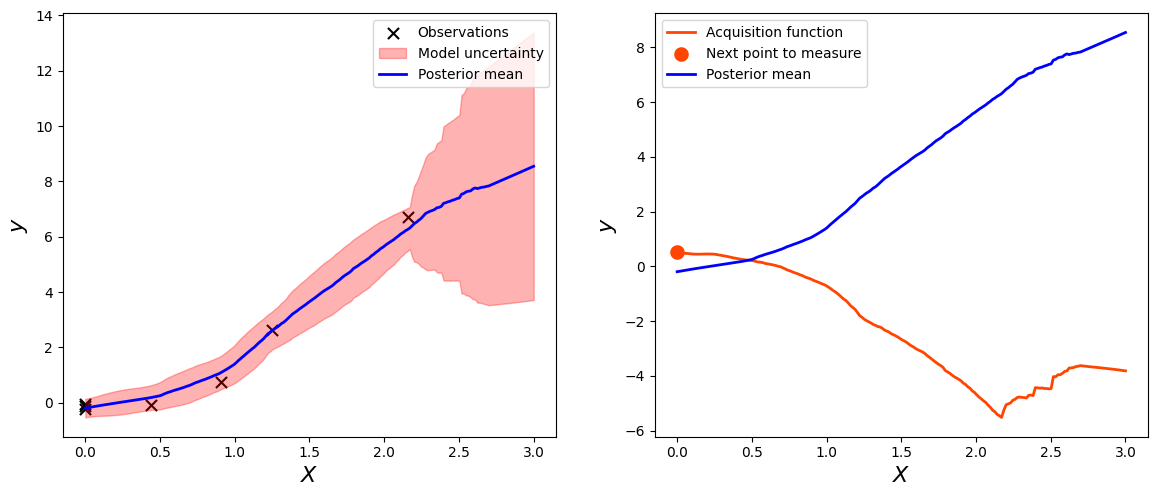


Exploration step 4


sample: 100%|██████████| 600/600 [00:08<00:00, 73.40it/s, 1023 steps of size 3.64e-03. acc. prob=0.76] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.42      0.90      1.25      0.15      2.73     44.74      1.05
          c      2.82      1.14      2.71      0.57      3.91     13.39      1.01
k_length[0]      1.23      1.23      0.84      0.09      2.57     86.87      1.02
    k_scale      1.52      2.33      0.87      0.04      3.39     98.07      1.03
      noise      0.39      0.34      0.30      0.03      0.72    155.50      1.00
          t      1.51      0.59      1.34      0.81      2.66     29.85      1.07



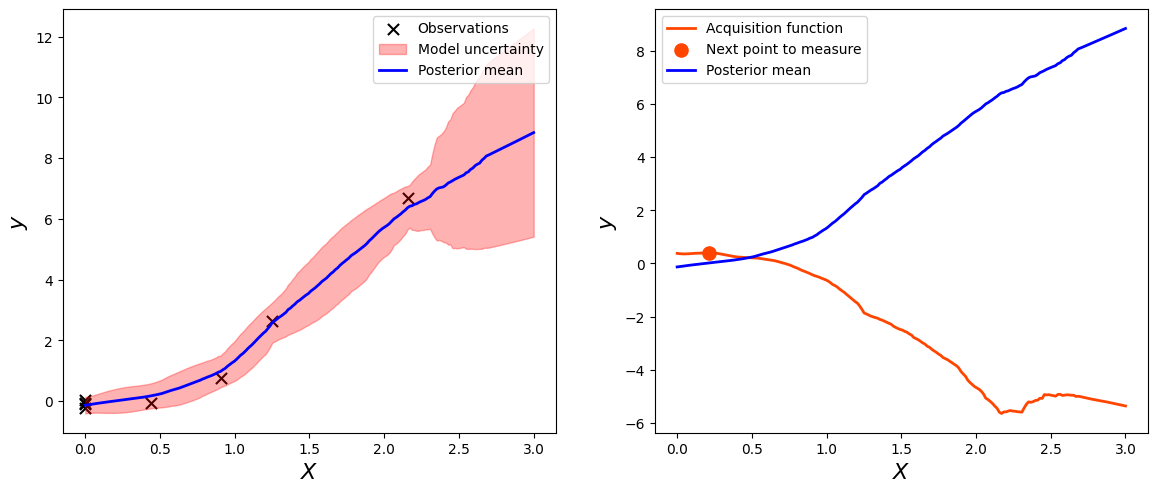


Exploration step 5


sample: 100%|██████████| 600/600 [00:07<00:00, 81.17it/s, 511 steps of size 1.40e-02. acc. prob=0.71] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.20      0.72      1.08      0.18      2.31    118.66      1.01
          c      2.74      0.60      2.78      1.77      3.59     60.39      1.03
k_length[0]      1.40      1.86      0.91      0.10      2.72     74.18      1.01
    k_scale      1.08      1.42      0.72      0.01      2.25     99.57      1.00
      noise      0.32      0.26      0.24      0.03      0.66    229.64      1.00
          t      1.33      0.45      1.22      0.78      2.19    130.42      1.02



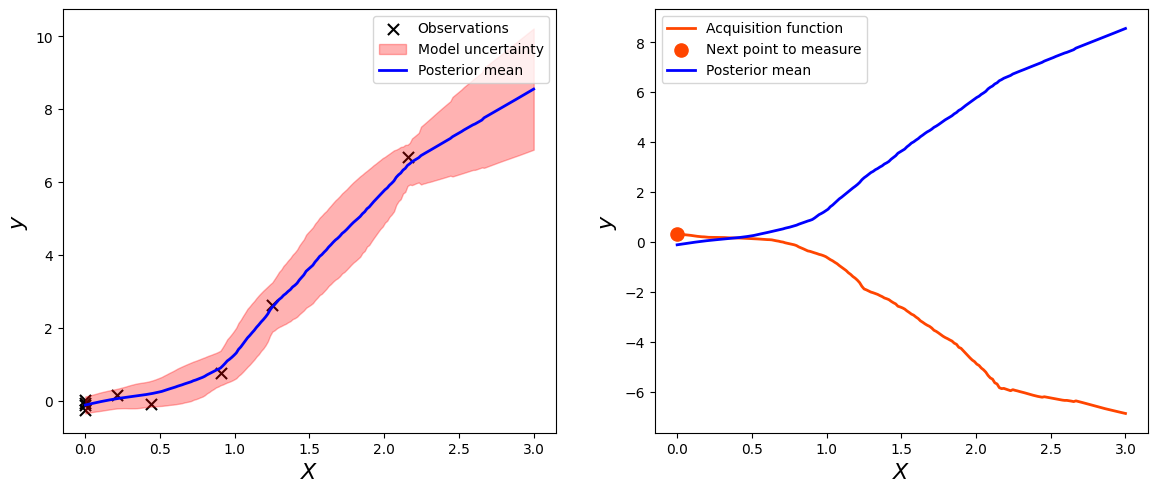


Exploration step 6


sample: 100%|██████████| 600/600 [00:10<00:00, 59.79it/s, 1023 steps of size 1.08e-03. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.58      0.81      2.63      1.31      4.00     46.50      1.00
          c     10.26      4.28     10.46      2.78     16.25      5.25      1.09
k_length[0]      0.95      0.43      0.91      0.15      1.46    122.27      1.02
    k_scale      2.22      1.24      1.89      0.55      4.00     21.54      1.01
      noise      0.24      0.25      0.14      0.02      0.59     10.48      1.17
          t      2.37      0.38      2.43      2.18      2.69     17.34      1.04



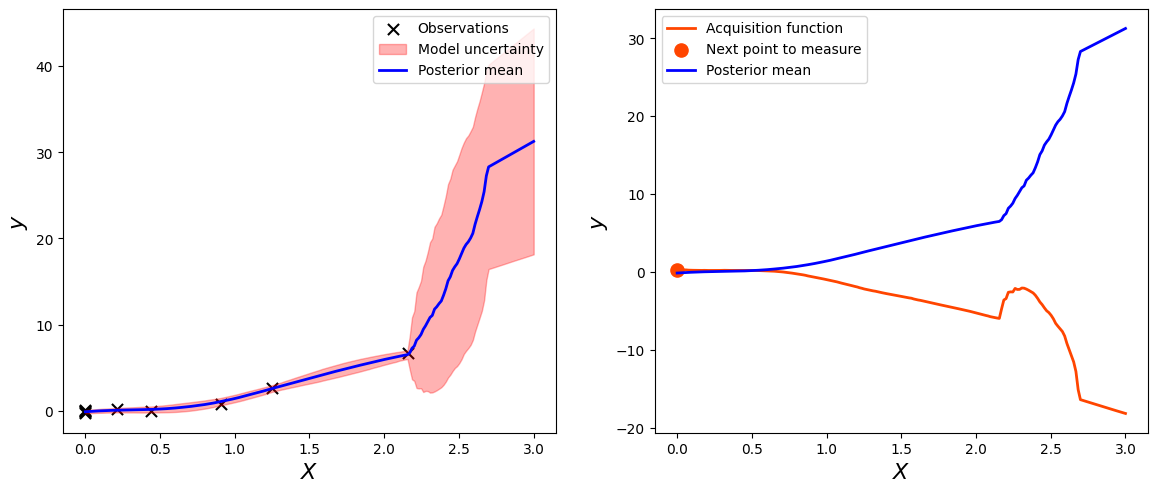


Exploration step 7


sample: 100%|██████████| 600/600 [00:11<00:00, 52.58it/s, 1023 steps of size 2.93e-03. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.36      0.79      1.29      0.20      2.54     72.08      1.01
          c      2.78      0.54      2.79      1.83      3.48     63.91      1.03
k_length[0]      0.94      0.81      0.74      0.13      1.78     78.85      1.01
    k_scale      1.30      1.59      0.81      0.04      2.70    117.85      1.00
      noise      0.17      0.17      0.12      0.02      0.36     93.99      1.00
          t      1.31      0.49      1.21      0.52      2.05     59.23      1.00



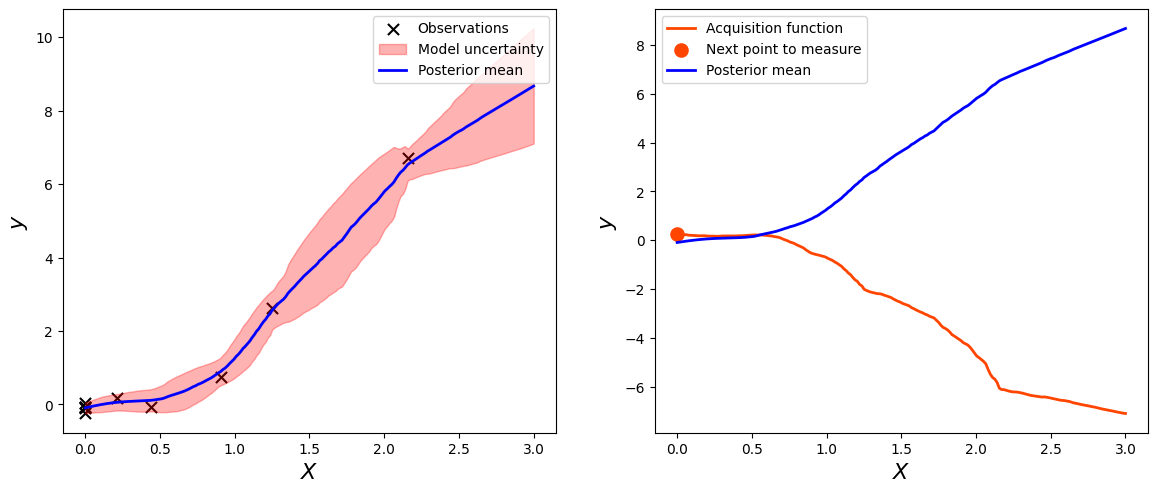


Exploration step 8


sample: 100%|██████████| 600/600 [00:11<00:00, 53.14it/s, 1023 steps of size 1.28e-03. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.75      0.92      1.62      0.36      3.07     23.39      1.06
          c      3.23      1.17      2.97      1.32      4.80     16.49      1.19
k_length[0]      0.78      0.39      0.73      0.21      1.40     44.15      1.02
    k_scale      1.68      1.45      1.34      0.22      3.16     28.72      1.00
      noise      0.11      0.12      0.07      0.02      0.23     18.82      1.04
          t      1.58      0.65      1.47      0.76      2.69     17.61      1.11



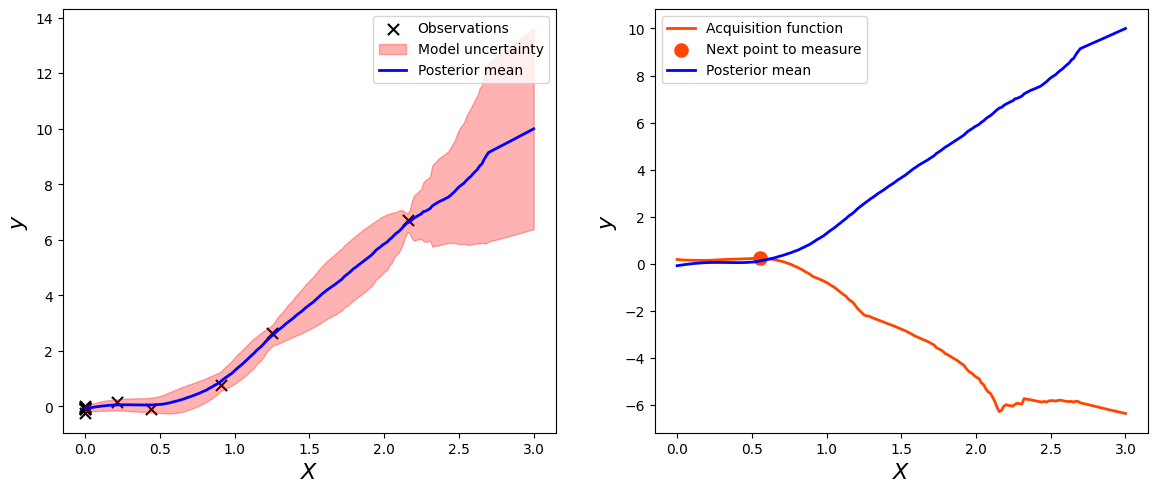


Exploration step 9


sample: 100%|██████████| 600/600 [00:12<00:00, 46.66it/s, 1023 steps of size 2.08e-03. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.61      0.84      1.51      0.32      2.86     23.03      1.00
          c      3.13      0.84      2.96      1.65      4.32     14.61      1.10
k_length[0]      1.04      0.93      0.81      0.11      1.86     67.30      1.00
    k_scale      1.39      1.18      1.01      0.11      3.07     76.63      1.02
      noise      0.10      0.10      0.08      0.01      0.20     60.02      1.00
          t      1.45      0.57      1.20      0.91      2.67     15.56      1.09



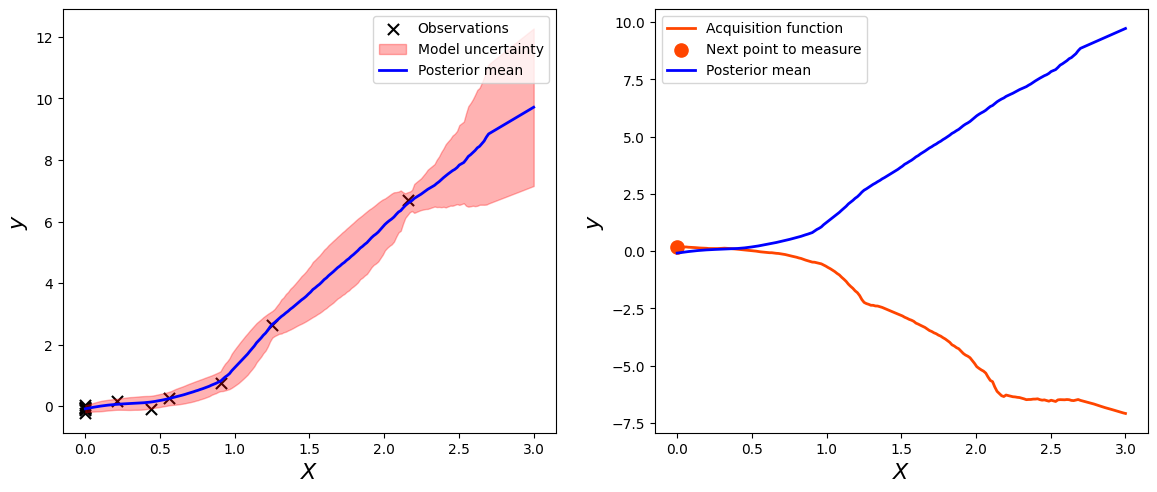

In [ ]:
X, y = Xo, yo  # start from the same set of observations

rng_key, rng_key_predict = gpax.utils.get_keys(1)

for i in range(9):
    print("\nExploration step {}".format(i+1))
    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
    gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1, print_summary=1)

    # Compute acquisition function and get coordinate of the next point
    #obj = gpax.acquisition.UE(rng_key_predict, gp_model, X_test)

    #Upper confidence bound
    obj = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta= 1, maximize=False, noiseless=True)

    #Expected improvement
    #obj = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, xi=0.01, maximize=False, n=10, noiseless=True) #xi = 0.01

    next_point_idx = obj.argmax()

     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)

    # Plot observed points, mean prediction, and acqusition function
    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=True, n= 10)

    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))

    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_test, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_test, obj, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_test[next_point_idx], obj[next_point_idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_test, y_pred, lw=2, c='b', label='Posterior mean')
        #ax.plot(X_test, truefunc, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()


Make the prediction using all the newly discovered points:

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)
# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
gp_model.fit(rng_key, X, y, num_warmup = 200, num_samples = 400, num_chains = 1)
# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

sample: 100%|██████████| 600/600 [00:13<00:00, 43.21it/s, 1023 steps of size 2.13e-03. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.62      0.87      1.50      0.23      2.76     57.87      1.00
          c      2.75      0.62      2.79      1.54      3.49     24.97      1.14
k_length[0]      0.91      0.56      0.80      0.17      1.62     64.82      1.04
    k_scale      1.54      1.57      1.08      0.10      3.56     76.12      1.01
      noise      0.09      0.08      0.07      0.01      0.17     56.33      1.04
          t      1.53      0.54      1.41      0.90      2.59     28.71      1.02



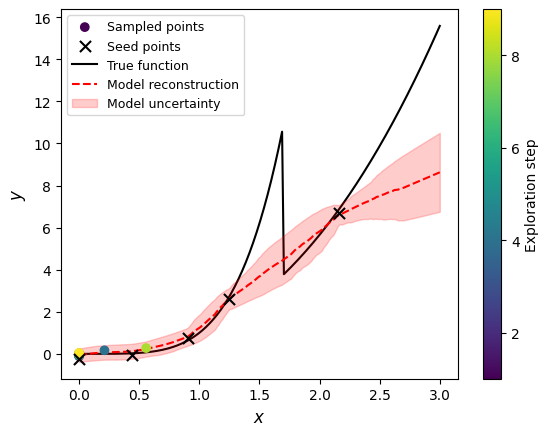

In [ ]:
# Plot results
plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=0)

plt.fill_between(X_test, y_pred - y_sampled.std((0,1)), y_pred + y_sampled.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Even though it required more steps (and each step took longer to converge), it is still able to reconstuct the underlying discontinuous function. Note that the vanilla GP won't be able to do so (you can check it by removing the mean_fn and mean_fn_prior arguments from the GP initialization and rerunning the process).